<a href="https://colab.research.google.com/github/GarrettIvers/monocular/blob/main/Phase3Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 2 Synthetic Data by Garrett Iverson
Based on Keras Monocular Depth Estimation: https://keras.io/examples/vision/depth_estimation/

## Setup & Dataset
download synthetic dataset here

https://drive.google.com/drive/folders/12Hy8Pibq3kLzdukywEs4LtI7F0r3ExnU?usp=sharing

In [1]:
#!pip uninstall tensorflow

#!pip install tensorflow==2.8.0

In [2]:
import os
import sys

import tensorflow as tf
from keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

In [3]:
path = "/content/drive/MyDrive/C/SGPU_SyntheticDataset"

# filelist = []
filelist = os.listdir("/content/drive/MyDrive/C/SGPU_SyntheticDataset")
for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.startswith("basename_color_")],
    "depth": [x for x in filelist if x.startswith("basename_depth_")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

## Hyperparameters

Next step: less epochs, lower LR

In [28]:
HEIGHT = 256
WIDTH = 256
LR = 0.0001
EPOCHS = 200
BATCH_SIZE = 16

vbatchsize = 70
savemodelname = "depthE200LR1.h5"
loadmodelname = savemodelname

## Pipeline

funky

In [5]:
# The pipeline takes a dataframe containing the path for the RGB images, as well as the depth and depth mask files.
# It reads and resize the RGB images.
# It reads the depth and depth mask files, process them to generate the depth map image and resize it.
# It returns the RGB images and the depth map images for a batch.
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map):
        """Load input and target image."""
        # print(image_path)
        image_path = "/content/drive/MyDrive/C/SGPU_SyntheticDataset/" + image_path
        # print(image_path)
        # print(depth_map)
        depth_map = "/content/drive/MyDrive/C/SGPU_SyntheticDataset/" + depth_map
        # print(depth_map)

        image_ = cv2.imread(image_path)
        # print(image_)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)
        # image_ = tf.expand_dims(image_, axis=2)

        # depth_map = np.load(depth_map).squeeze()
        depth_map = cv2.imread(depth_map, cv2.IMREAD_UNCHANGED)
        depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
        # depth_map = depth_map / np.max(depth_map)
        # mask = np.load(mask)
        # mask = mask > 0

        #max_depth = min(300, np.percentile(depth_map, 99))
        #depth_map = np.clip(depth_map, self.min_depth, max_depth)
        # depth_map = np.log(depth_map, where=mask)

        # depth_map = np.ma.masked_where(~mask, depth_map)

        #depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        #depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        #depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                # self.data["mask"][batch_id],
            )

        return x, y

## Visualize Samples

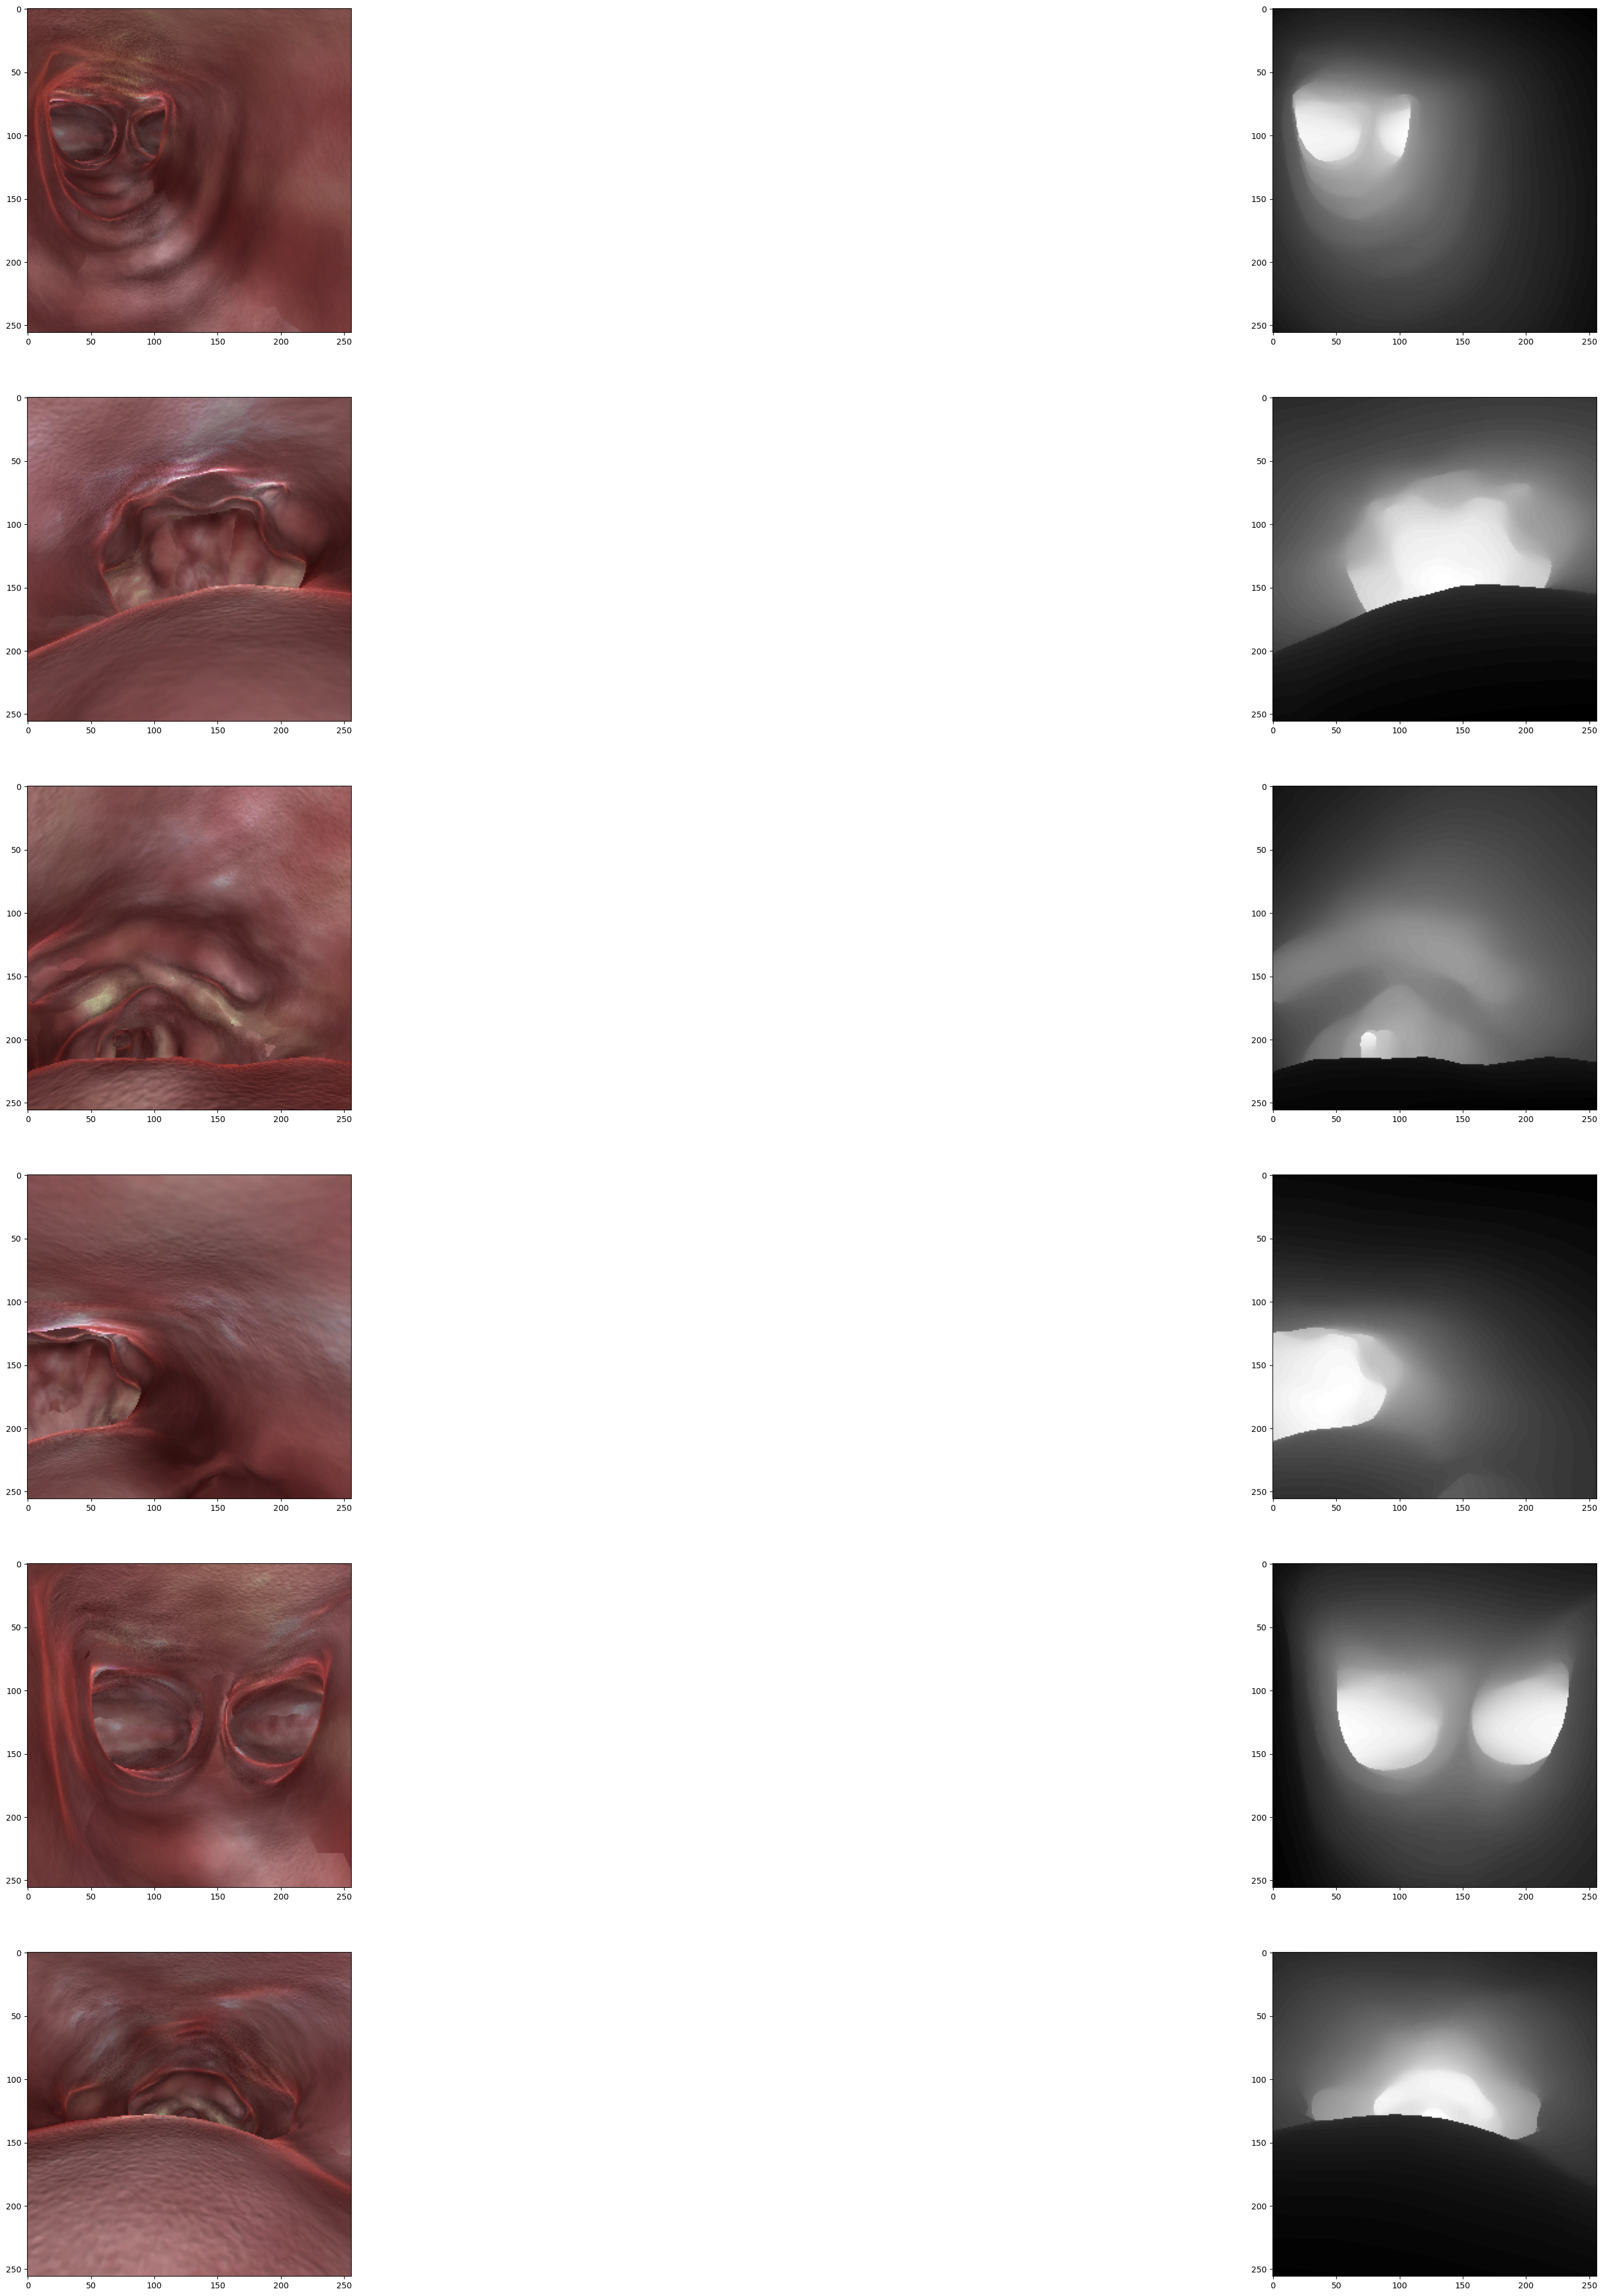

In [19]:
# Samples
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    #cmap = plt.cm.jet
    #cmap = plt.viridis
    cmap = plt.cm.gray
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(vbatchsize, 3, figsize=(50, 50))
        # Create a folder to save the images
        folder_name = 'depth_map_images'
        os.makedirs(folder_name, exist_ok=True)
        for i in range(70):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

            data = pred[i].squeeze()
            filename = os.path.join(folder_name, f'image_{i}.png')
            plt.imsave(filename, data, cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=vbatchsize, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

### Point cloud and debug

In [6]:
if df.empty:
    raise ValueError("The dataframe 'df' is empty.")

In [8]:
df

image                  depth
22  basename_color_29.png  basename_depth_29.png
0    basename_color_0.png   basename_depth_0.png
49  basename_color_53.png  basename_depth_53.png
4   basename_color_12.png  basename_depth_12.png
55  basename_color_59.png  basename_depth_59.png
..                    ...                    ...
23   basename_color_3.png   basename_depth_3.png
20  basename_color_27.png  basename_depth_27.png
60  basename_color_63.png  basename_depth_63.png
14  basename_color_21.png  basename_depth_21.png
51  basename_color_55.png  basename_depth_55.png

[71 rows x 2 columns]

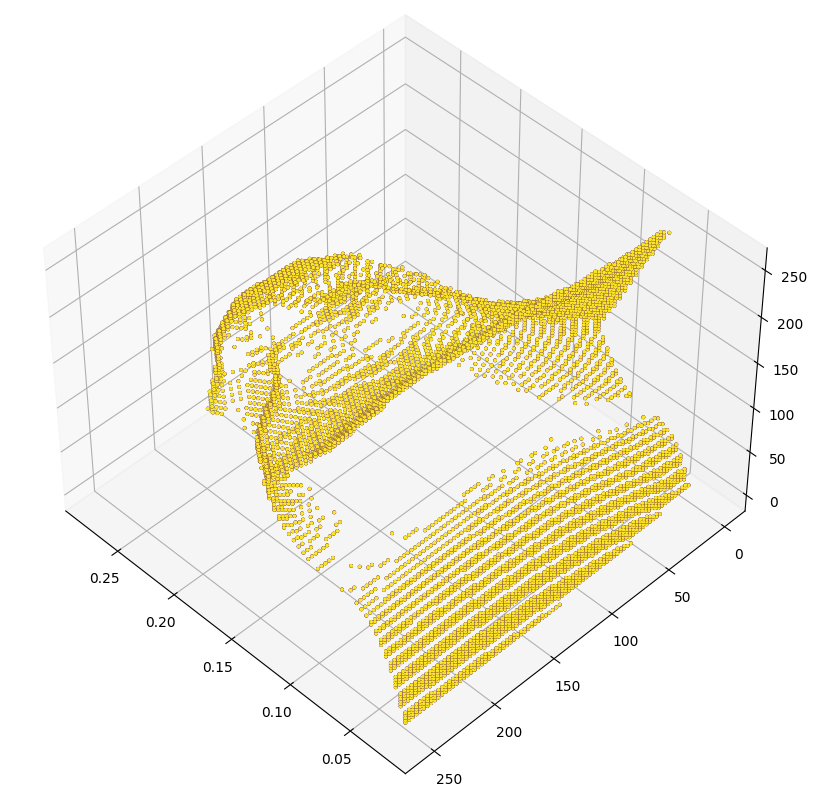

In [9]:
# 3D point cloud
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

## Building The Model

In [8]:
# The basic model is from U-Net.
# Additive skip-connections are implemented in the downscaling block.
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization(synchronized=False)
        self.bn2b = tf.keras.layers.BatchNormalization(synchronized=False)

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization(synchronized=False)
        self.bn2b = tf.keras.layers.BatchNormalization(synchronized=False)
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [9]:
# Loss
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

## Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Compile the model
model.compile(optimizer)

train_loader = DataGenerator(
    data=df[:71].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[71:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
)

Epoch 1/200
5/5 [==============================] - 14s 236ms/step - loss: 0.8749
Epoch 2/200
5/5 [==============================] - 1s 220ms/step - loss: 0.6125                               
Epoch 3/200
5/5 [==============================] - 4s 993ms/step - loss: 0.3396                                                                                                                                                                                                                                                                                                                                                                                                        
Epoch 4/200
5/5 [==============================] - 5s 1s/step - loss: 0.2033                                                                                                                                                                                                                                                                    

In [ ]:
# prompt: save the model

model.save_weights(savemodelname)

## Visualize Output

### Test newly trained model

In [27]:
print(len(df))

71


In [ ]:
# load trained model
test_loader = next(
    iter(
        DataGenerator(
            data=df[1:].reset_index(drop="true"), batch_size=vbatchsize, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

### Load model weights and test existing model

In [10]:
# prompt: load the saved model
loadmodelname = "depthE100LR1.h5"

new_model = DepthEstimationModel()
new_model.build(input_shape=(None, HEIGHT, WIDTH, 3))
new_model.load_weights(loadmodelname)

3/3 [==============================] - 0s 126ms/step


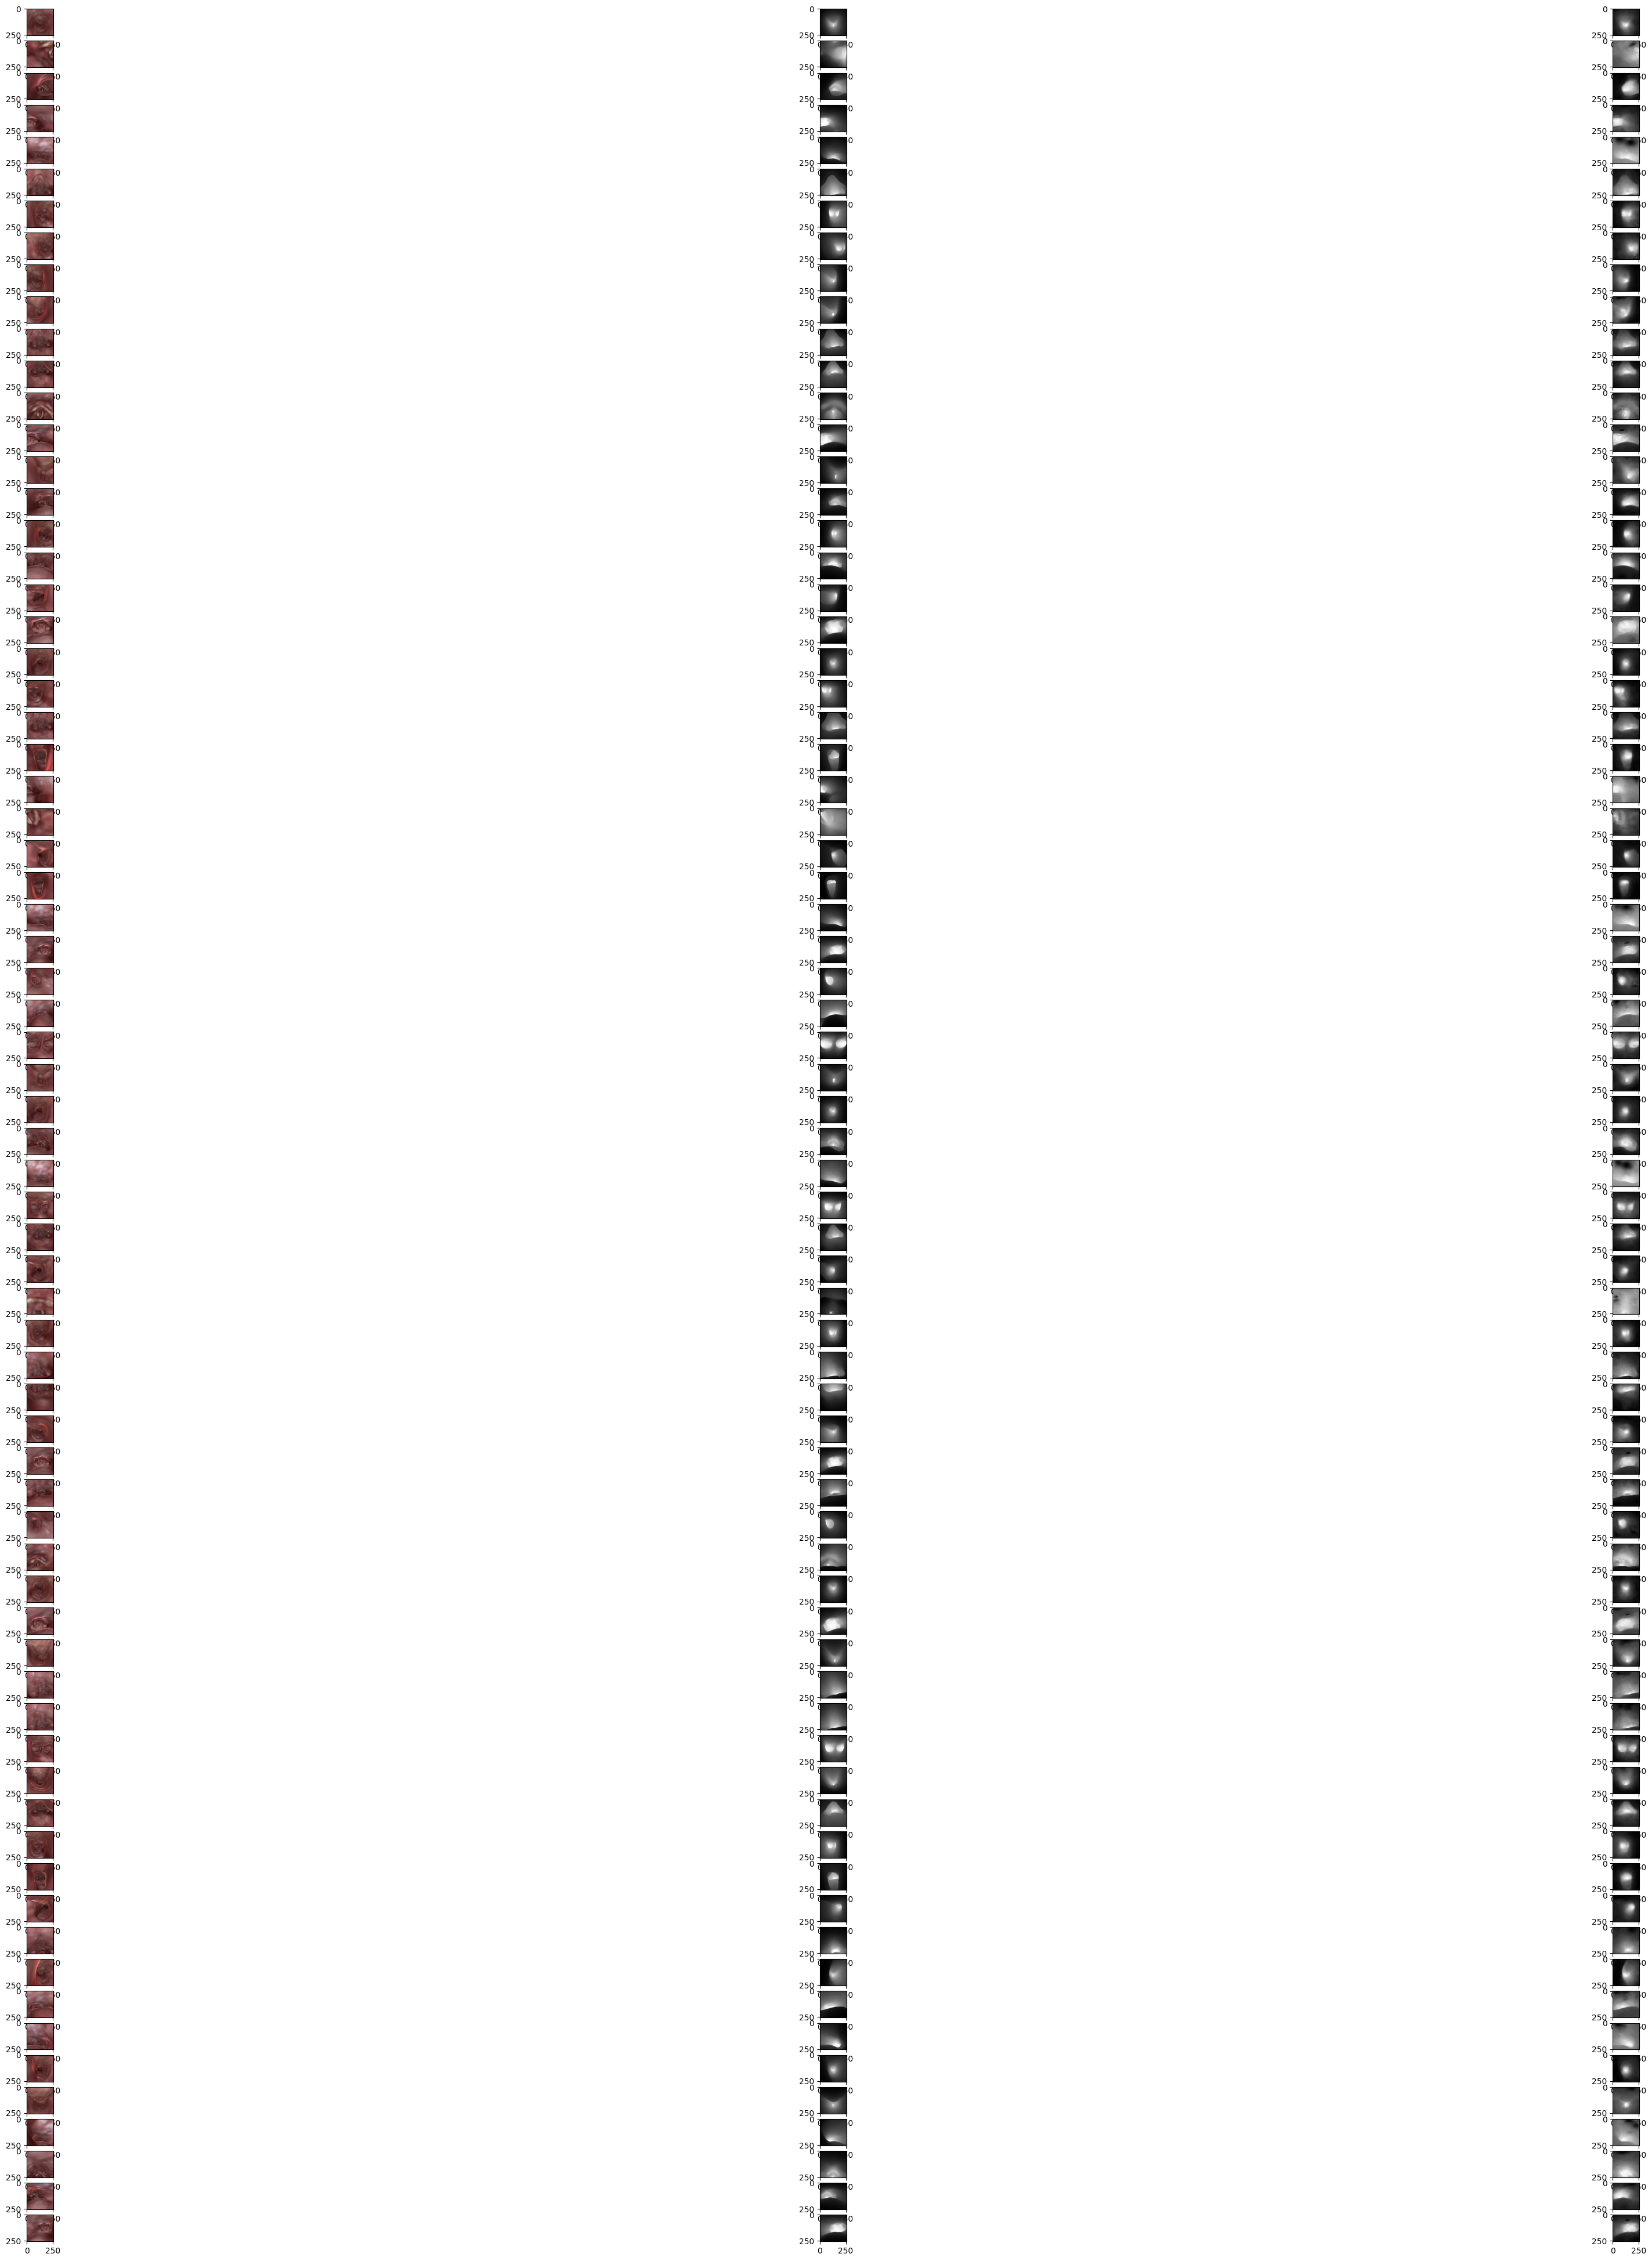

In [14]:
# load existing model
test_loader = next(
    iter(
        DataGenerator(
            data=df[1:].reset_index(drop="true"), batch_size=vbatchsize, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=new_model)

## End

In [ ]:
!zip -r /content/depth_map_images.zip /content/depth_map_images

https://www.youtube.com/watch?v=__dHYGe9bQs

https://derivative.ca/community-post/asset/pointclouds-2d-images-depth/62516

https://www.youtube.com/watch?v=WoiI_Pn9yHw

https://huggingface.co/docs/diffusers/en/tutorials/basic_training
